In [28]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

In [29]:
labeling = pd.read_csv('../input/data/train/labeling_ver2.csv')

labeling_label = labeling['label'].value_counts()

age_groups = []
for i in range(len(labeling)):
    if labeling['age'].iloc[i] < 30:
        age = 'A'
    elif 30<=labeling['age'].iloc[i] < 60:
        age = 'B'
    else:
        age = 'C'
    age_groups.append(age)
age_groups = {'age_group' : age_groups}
labeling['age_group'] = pd.DataFrame(age_groups)
labeling.tail()

,Unnamed: 0,img_path,label,state,gender,age,age_group
18895,18895,./train/images/006959_male_Asian_19/mask2.jpg,0,mask,male,19,A
18896,18896,./train/images/006959_male_Asian_19/mask3.jpg,0,mask,male,19,A
18897,18897,./train/images/006959_male_Asian_19/mask4.jpg,0,mask,male,19,A
18898,18898,./train/images/006959_male_Asian_19/mask5.jpg,0,mask,male,19,A
18899,18899,./train/images/006959_male_Asian_19/normal.jpg,12,normal,male,19,A


1. label의 분포

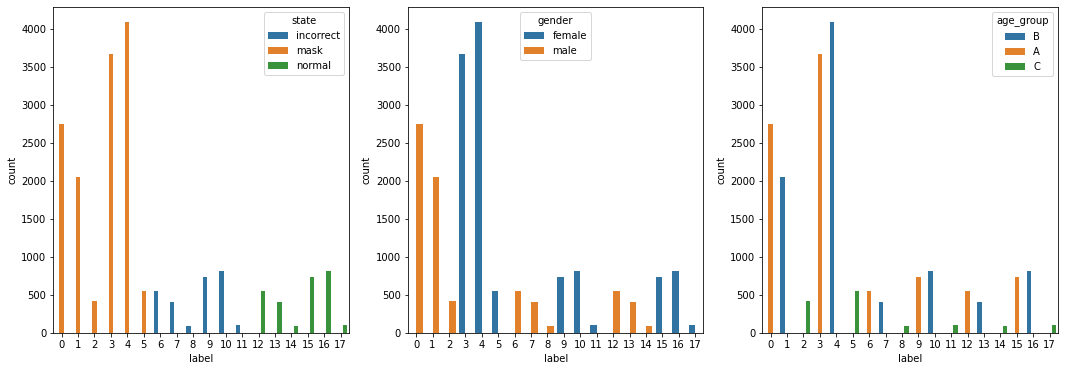

In [30]:
fig, axes = plt.subplots(1,3,figsize = (18,6))
sns.countplot(x = 'label', data = labeling, hue = 'state', ax = axes[0])
sns.countplot(x = 'label', data = labeling, hue = 'gender', ax = axes[1])
sns.countplot(x = 'label', data = labeling, hue = 'age_group', ax = axes[2])

1 - (1) label 값의 독립적 분포

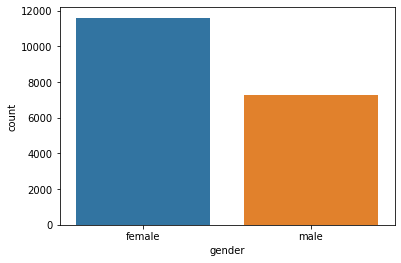

In [31]:
# gender
sns.countplot(x = 'gender', data = labeling)

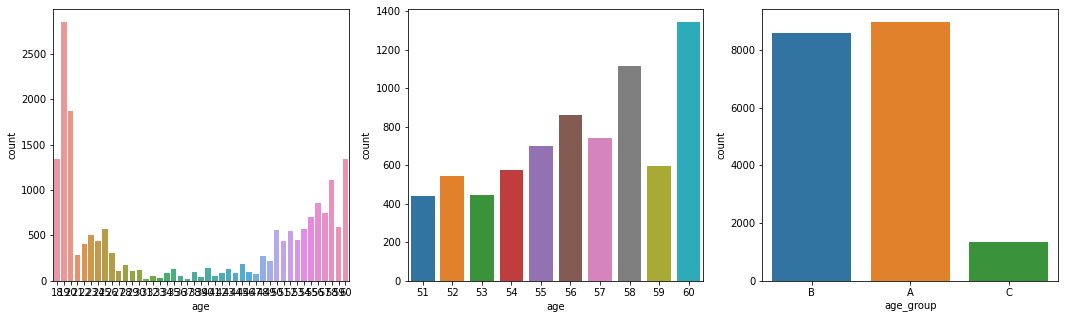

In [32]:
# age
fig, axes = plt.subplots(1,3,figsize = (18,5))

sns.countplot(x = 'age', data = labeling, ax = axes[0])
sns.countplot(x = 'age', data = labeling[labeling['age'] > 50], ax = axes[1])
sns.countplot(x = 'age_group', data = labeling, ax = axes[2]) 

1 - (2) label들 간의 관계 분포

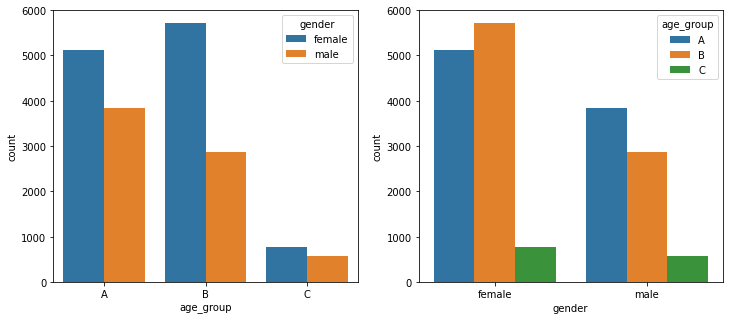

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(x='age_group',data=labeling, order = ['A','B','C'],
              hue='gender', 
              ax=axes[0]
             )

sns.countplot(x='gender',data=labeling,
              hue='age_group',
              hue_order = sorted(labeling['age_group'].unique()),
              ax=axes[1]
             )

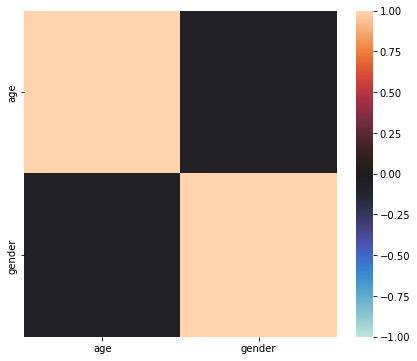

In [34]:
fig,ax = plt.subplots(1,1,figsize = (7,6))

change_dict = {'female':0, 'male':1}
labeling2 = labeling.replace({'gender' : change_dict})
sns.heatmap(labeling2[['age', 'gender']].corr(), ax=ax,
            vmin = -1, vmax = 1, center = 0)
plt.show() ## 특정 성별에 더 많은 age를 두거나 하지는 않았음! 독립적인듯..

2. Input X에 대한 분석

2 - 1) image size

In [35]:
from dask import bag, diagnostics
from PIL import Image

def get_dims(file):
    img = cv2.imread(file)
    h,w = img.shape[:2]
    return h, w

image_names = []

for i in range(len(labeling)):
    file = labeling['img_path'].iloc[i]
    file = os.path.join('../input/data/',file[2:])
    image_names.append(file)

dimsbag = bag.from_sequence(image_names).map(get_dims)
with diagnostics.ProgressBar():
    dims = dimsbag.compute()
dim_df = pd.DataFrame(dims, columns=['height', 'width'])

[########################################] | 100% Completed |  9.6s


In [36]:
labeling[['height', 'width']] = dim_df
labeling.head()

,Unnamed: 0,img_path,label,state,gender,age,age_group,height,width
0,0,./train/images/000001_female_Asian_45/incorrec...,10,incorrect,female,45,B,512,384
1,1,./train/images/000001_female_Asian_45/mask1.jpg,4,mask,female,45,B,512,384
2,2,./train/images/000001_female_Asian_45/mask2.jpg,4,mask,female,45,B,512,384
3,3,./train/images/000001_female_Asian_45/mask3.jpg,4,mask,female,45,B,512,384
4,4,./train/images/000001_female_Asian_45/mask4.jpg,4,mask,female,45,B,512,384


In [37]:
import hvplot.pandas

sizes = dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})
sizes.hvplot.scatter(x='height', y='width', size='count', xlim=(0,1200), ylim=(0,1200), grid=True, xticks=2, 
        yticks=2, height=500, width=600).options(scaling_factor=0.1, line_alpha=1, fill_alpha=0)


:Scatter   [height]   (width,count)

2 - 2) RGB 채널별 통계값

In [ ]:
means, stds = [], []
for i in range(len(labeling)):
    file = labeling['img_path'].iloc[i]
    file = os.path.join('../input/data/',file[2:])
    image = cv2.imread(file)
    dims = np.shape(image)
    pixel_matrix = np.reshape(image, (-1, dims[-1]))
    mean = pixel_matrix.mean(axis = 0)
    std = pixel_matrix.std(axis = 0)
    means.append(mean)
    stds.append(std)
rgb_mean = pd.DataFrame(means, columns = ['R', 'G', 'B'])
rgb_std = pd.DataFrame(stds, columns = ['R','G','B'])

In [ ]:
fig, axes = plt.subplots(1,3,figsize = (18,5))

sns.countplot(x = 'R', data = rgb_mean, ax = axes[0])
sns.countplot(x = 'G', data = rgb_mean, ax = axes[1])
sns.countplot(x = 'B', data = rgb_mean, ax = axes[2])